In [1]:
# Set local python and nltk paths
import sys
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/PyTorch27/lib/python2.7/site-packages')
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/PyTorch27/lib/python2.7/site-packages/setuptools-27.2.0-py2.7.egg')
sys.path.insert(0,'/vol/medic02/users/ag6516/miniconda/envs/PyTorch27/lib/python2.7/site-packages/IPython/extensions')
sys.path
import nltk
nltk.data.path = ['/vol/medic02/users/ag6516/nltk_data']

In [2]:
import csv
import pandas as pd
import numpy as np
from read_data import read_csv_into_df

In [3]:
fields = ['Accession', 'Clinical history', 'Comment', 'Report text']
dir = ('/vol/medic02/users/ag6516/x_ray_fracture_localisation/')#
# dir = ('/Users/Aydan/PhD/x_ray_fracture_localisation/')

with open(dir + 'data/Reports/XKNEB_Jan_Dec_2015_anon.csv', 'rU') as csvfile:
    data1 = csv.reader(csvfile, delimiter=',')
    headers1 = data1.next()

with open(dir + 'data/Reports/XKNEB_Jan_Dec_2016_anon.csv', 'rU') as csvfile:
    data2 = csv.reader(csvfile, delimiter=',')
    headers2 = data2.next()

# with open(dir + 'data/Reports/XKNEB_Jan_Jul_2017_anon.csv', 'rU') as csvfile:
#     data3 = csv.reader(csvfile, delimiter=',')
#     headers3 = data3.next()

cols1 = [headers1.index(item) for item in fields]
cols2 = [headers2.index(item) for item in fields]
# cols3 = [headers3.index(item) for item in fields]

In [4]:
df1 = read_csv_into_df(dir + 'data/Reports/XKNEB_Jan_Dec_2015_anon.csv', fields, cols1)
df2 = read_csv_into_df(dir + 'data/Reports/XKNEB_Jan_Dec_2016_anon.csv', fields, cols2)

In [5]:
df = pd.concat([df1,df2])
print df.count()

Accession           3576
Clinical history    2232
Comment             2402
Report text         3576
dtype: int64


In [6]:
# Check for missing information
df_nans = df[df.isnull().any(axis=1)]
df_nans.to_csv('missing_info.csv', sep=',')

In [7]:
df.to_csv('cleaned_reports.csv', sep=',')

In [8]:
# Basic filtering and stats
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import random
random.seed(123)
np.random.seed(123)

reports = []
reports_tok = []
labels = []
words = []
for i, row in df.iterrows():
    report = row['Report text'].decode('utf-8').lower()
    
    # Replace unnecessary punctuation 
    for char in ['~', '"']:
        report = report.replace(char, '')
        
    for char in ['!', '?', ';', ':', '.']:
        report = report.replace(char, ' . ')
    
    for char in ['(', ')', ',', '/']:
        report = report.replace(char, ' , ')
        
    # Tokenize
    report_tok = word_tokenize(report)
    
    # Remove stopwords
    filtered_report_tok = [word for word in report_tok if word not in stopwords.words('english')]
    filtered_report = ' '.join(filtered_report_tok)
    
    reports.append(filtered_report)
    reports_tok.append(filtered_report_tok)
    labels.append(row['Accession'])
    [words.append(word) for word in filtered_report_tok]

print 'Vocab length: ', len(sorted(set(words)))
print 'Avg no. of appearances: ', len(words)/len(sorted(set(words)))
fdist_all = nltk.FreqDist(words)
freqs = [freq for _, freq in fdist_all.most_common()]
print 'STD: ', np.std(freqs)
#print fdist_all.hapaxes()
print 'Number of reports: ', len(reports)

Vocab length:  1770
Avg no. of appearances:  51
STD:  387.271636453
Number of reports:  3576


Populating the interactive namespace from numpy and matplotlib
['.', 'knee', 'joint', 'xr', ',', 'medial', 'changes', 'degenerative', 'seen', 'space', 'right', 'patellofemoral', 'left', 'joints', 'change', 'compartment', 'previous', 'bilaterally', 'noted', 'loss', 'comparison', 'narrowing', 'spaces', 'compartments', 'tibiofemoral', 'mild', 'bilateral', 'osteophyte', 'imaging', 'bony', 'significant', 'moderate', 'osteophytosis', 'formation', 'within', 'lateral', 'made', 'knees', 'tibial', 'femoral', 'minor', 'osteoarthritic', 'marked', 'evidence', 'severe', 'preserved', 'acute', 'appearances', 'reduction', 'bone']


/vol/medic02/users/ag6516/miniconda/envs/PyTorch27/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['char', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


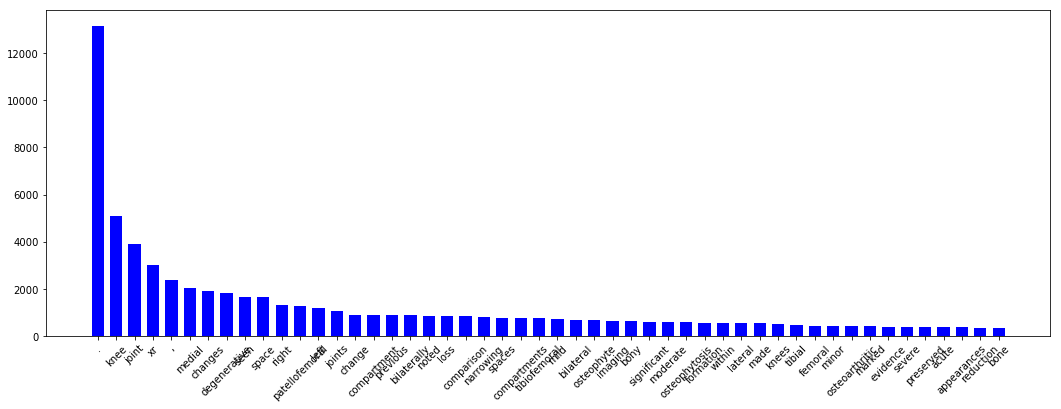

In [11]:
# Vocab stats
import matplotlib.pyplot as plt
#%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (18, 6)

hist = [(word,freq) for word, freq in fdist_all.most_common(50)]
#fdist_all.plot(50)

words = [str(word) for word in zip(*hist)[0]]
print words
counts = range(len(words))
frequency = zip(*hist)[1]

plt.bar(counts, frequency, 1/1.5, color="blue", align='center')
plt.xticks(counts, words, rotation=45)
fig = plt.gcf()

# 1. Doc2Vec
From the gensim library: doc2vec can be used to embed documents through a distributed memory and distributed bag of words approach (Mikolov 2014)

__[Quoc Le and Tomas Mikolov. Distributed Representations of Sentences and Documents](https://arxiv.org/pdf/1405.4053v2.pdf)__

In [109]:
# Generate Doc2Vec embeddings for reports
import gensim
from gensim.models.doc2vec import LabeledSentence

class DocIterator(object):
    def __init__(self, doc_list, labels_list):
        self.labels_list = labels_list
        self.doc_list = doc_list
    def __iter__(self):
        for idx, doc in enumerate(self.doc_list):
            yield LabeledSentence(words=doc, tags=[self.labels_list[idx]])
            
it = DocIterator(reports, labels)

## 1.1 Training doc2vec model
The model is trained on the entire text for 10 iterations

In [59]:
# Train model
model_d2v = gensim.models.Doc2Vec(size=300, min_count=0, alpha=0.025, min_alpha=0.025)
model_d2v.build_vocab(it)
#training of model
for epoch in range(10):
    print 'iteration ' +str(epoch+1)
    model_d2v.train(it, total_examples=model.corpus_count, epochs=model.iter)
    model_d2v.alpha -= 0.002
    model_d2v.min_alpha = model.alpha
    model_d2v.train(it, total_examples=model.corpus_count, epochs=model.iter)
#save the created model
model_d2v.save('doc2vec.model')

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10


In [113]:
# Or load pre-trained model
model_d2v = gensim.models.Doc2Vec.load('doc2vec.model')

## 1.2 Sampling report embeddings
We can test the embeddings by taking a sample of most simlar documents to a randomly sampled report

In [115]:
# Test model
pd.options.display.max_colwidth = 4000
label_sample = random.choice(labels)
report_sample = df.loc[df['Accession'] == label_sample]['Report text']
print "Sample document: \n"
print report_sample.to_string()

most_similar = model_d2v.docvecs.most_similar(label_sample)
print "\nMost similar documents: \n"

for label, _ in most_similar:
    print (df.loc[df['Accession'] == label]['Report text']).to_string()
    print ''

Sample document: 

722    XR Knee Both : \nAP views only.\nModerate degenerative changes are seen bilaterally at the tibiofemoral compartments. Chondrocalcinosis is seen. No acute bony injury identified on these images.

Most similar documents:
413    Bilateral mild narrowing of the medial joint space. No destructive bony lesion noted.

2127    XR Knee Both: \nNo previous xray available for comparison.\n\nMinimal narrowing of the medial joint compartments on both sides but no obvious bony changes seen.

538    XR Knee Both : There is mild medial joint space narrowing bilaterally. There is no joint effusion no acute bony abnormality.

2422    ~BXR Knee Both : \n~b\nThere is symmetrical loss of joint space involving the medial joint compartments bilaterally. The joint spaces and articular surfaces otherwise appear preserved. No bony injury identified.

1972    XR Knee Both : \nThere is narrowing of the medial tibiofemoral joints bilaterally consistent with minor degenerative change. Calc

## 1.3 Kmeans of doc2vec
The report embeddings can be grouped together using kmeans with a cluster size of 4. This is based on the assumption that we have 4 main pathologies present in the reports:
1. Osteoarthritis
2. Knee replacement
3. Fractures
4. No present pathologies

In [117]:
# Cluster documents using K-means
from sklearn.cluster import KMeans

def kmeans_clustering(vectors, num_clusters):
    # docvecs = model.docvecs
    kmeans = KMeans(init='k-means++', n_clusters=num_clusters, n_init=10)
    kmeans.fit(vectors)
    return kmeans.labels_
    
# Kmeans
num_clusters_d2v = 4
num_samples_kmeans_d2v = len(labels)

label_samples_d2v = random.choice(labels, num_samples_kmeans_d2v)
report_samples_d2v = []
embeddings_d2v = []
for label in label_samples_d2v:
    report_samples_d2v.append(df.loc[df['Accession'] == label]['Report text'])
    embeddings_d2v.append(model_d2v.docvecs[label])

# print report_samples_linebreaks[1]

kmeans_labels_d2v = kmeans_clustering(embeddings_dv2, num_clusters_d2v)

## 1.4 PCA of Clusters and Embeddings
The clustered report embeddings can be reduced using PCA to 2D and plotted. 

<IPython.core.display.Javascript object>


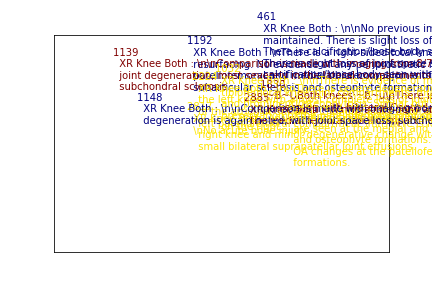

In [118]:
# Plot reports and clusters using PCA
#pylab.rcParams['figure.figsize'] = (18, 10)
%matplotlib notebook
%matplotlib notebook
from sklearn.decomposition import PCA

def plot_pca(vectors, reports, kmeans_labels, num_clusters, num_samples):
    reports_tuple = np.array(zip(vectors, reports, kmeans_labels))
    reports_tuple[np.random.choice(len(reports_tuple),10)]
    ss_vectors = reports_tuple[:,0].tolist()
    ss_reports = reports_tuple[:,1].tolist()
    ss_kmeans_labels = reports_tuple[:,2].tolist()
    
    reduced_data = PCA(n_components=2).fit_transform(ss_vectors)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    #h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    x_min, x_max = reduced_data[:, 0].min(), reduced_data[:, 0].max()
    y_min, y_max = reduced_data[:, 1].min(), reduced_data[:, 1].max()

    plt.figure()
    plt.clf()

    colours = plt.cm.jet(np.linspace(0, 1, num_clusters))
    
    for i, x, y in zip(range(num_samples), reduced_data[:, 0], reduced_data[:, 1]):
        plt.annotate(ss_reports[i], xy=(x, y), xytext=(0, 0), textcoords='offset points', color=colours[ss_kmeans_labels[i]])
        #plt.scatter(x, y, color=colours[ss_kmeans_labels[i]], alpha=.8, lw=2, label=ss_reports[i])
                                        
    #plt.title('K-means Clustering of Knee X-ray Reports (reduced with PCA)\n')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

# PCA
num_samples_pca = 10
report_samples_linebreaks = []
for report in report_samples_d2v:
    words = report.to_string().split()
    new_r = []
    for i, word in enumerate(words):
        new_r.append(word)
        if i%15==0:
            new_r.append(' \n ')
    report_samples_linebreaks.append(' '.join(new_r))

plot_pca(embeddings_d2v, report_samples_linebreaks, kmeans_labels_d2v, num_clusters_d2v, num_samples_pca)

## 1.5 Wordclouds of Clusters
Wordclouds can be used to get an idea of the dominant words in each cluster

### Evaluation
Clusters are not distinct, each cluster contains reference to degeneration (a sign of OA)
1. Cluster 1 has a high occurance of femoral, tibial, lateral. 
2. Cluster 2 has a high occurance of medial, loss, OA
3. Cluster 3 has a high occurance of patellofemoral, tibiafemoral
4. Cluster 4 is a mix of the above

Reports in cluster:  783
1151    XR Knee Both : \n\nComparison is made with imaging from 02/06/2015.\n\nThere is severe joint degeneration of the medial compartments bilaterally, with total loss of joint space, subchondral sclerosis and osteophytosis. There is mild joint degeneration of the patellofemoral compartments, with loss of joint space and osteophytosis.
Name: Report text, dtype: object
Reports in cluster:  1023
1629    XR Knee Both : \n\nComparison made to previous radiographs dated 19/07/2013\n\nX-ray right knee\n\nThere have been marginal changes, particular seen within the medial femoral tibial compartment with loss of joint space. There is some malalignment seen along the and lateral femoral tibial condyles cultures consistent with previous imaging.\n\nX-ray left knee\n\nNo significant change is seen in comparison to previous imaging. There is significant loss of medial femoral tibial compartment joint space with associated tibial articular surface sclerosing formation. Bi

/vol/medic02/users/ag6516/miniconda/envs/PyTorch27/lib/python2.7/site-packages/ipykernel/__main__.py:21: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal


Reports in cluster:  936
2099    XR Knee Both : \nImages taken for orthopaedic review.\nThere is joint space narrowing of the medial aspect of the femorotibial joint bilaterally.
Name: Report text, dtype: object
Reports in cluster:  834
1751    XR Knee Both : No significant bone or joint abnormality.
Name: Report text, dtype: object


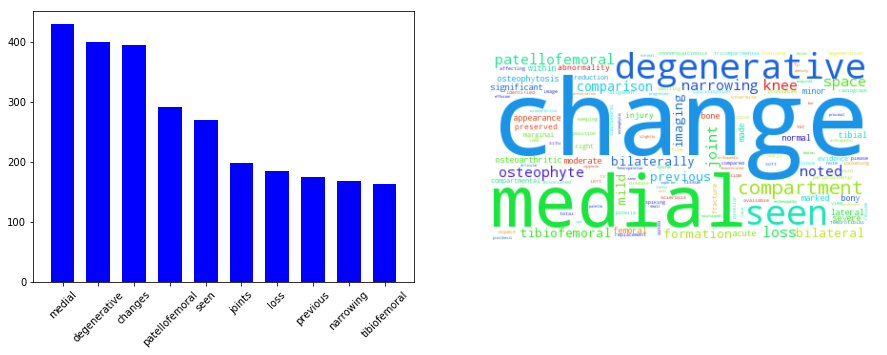

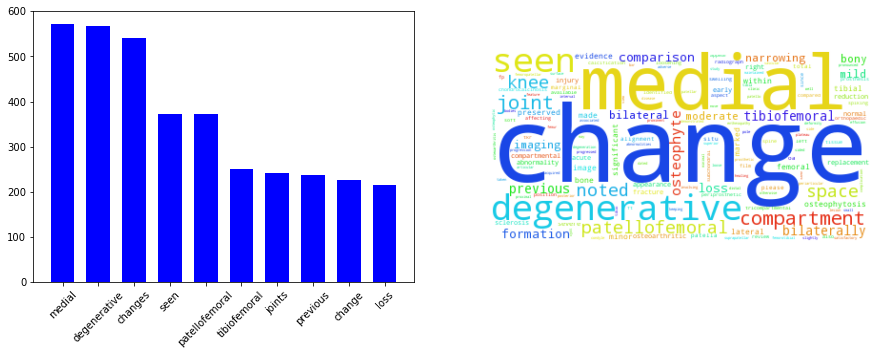

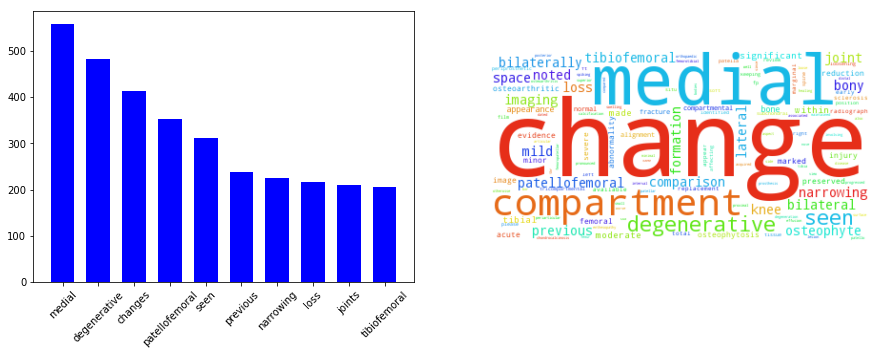

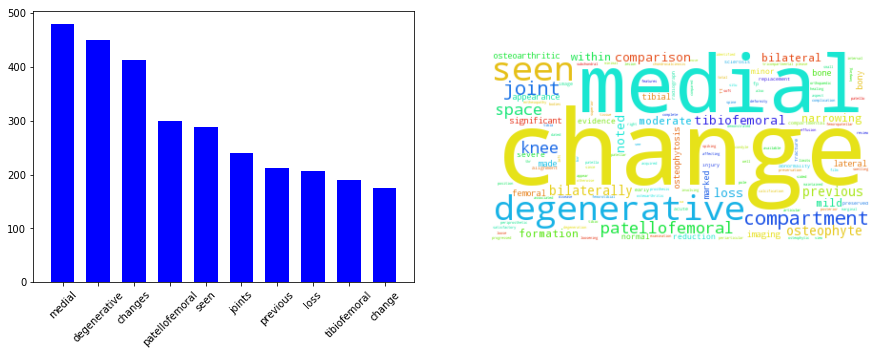

In [131]:
# Visualise words in clusters
from nltk.corpus import stopwords
from wordcloud import WordCloud
%matplotlib inline

mystoplist = ['xr', 'knee', 'both', 'x-ray', 'joint', 'left', 'right', 'space', ':']
stoplist = mystoplist + stopwords.words('english')

clusters_d2v = {}
for k in range(num_clusters_d2v):
    wc = WordCloud(background_color="white")
    #report_sample =  random.sample(list(report_list))
    #print report_sample
    clusters_d2v["cluster{0}".format(k)] = [i for i,j in zip(report_samples_d2v, kmeans_labels_d2v) if j==k]
    #print random.choice(list(clusters["cluster{0}".format(k)]))

    #print type(clusters["cluster{0}".format(k)])
    report_list = [' '.join(report).lower() for report in clusters_d2v["cluster{0}".format(k)]]
    report_text = ' '.join(report_list)
    report_words = report_text.split()
    filtered_report_text = [word for word in report_words if word not in stoplist]
    
    # frequency hist
    fig, (a1,a2) = plt.subplots(1, 2, figsize=(15, 5))
    fdist_all = nltk.FreqDist(filtered_report_text)
    hist = [(word,freq) for word, freq in fdist_all.most_common(10)]
    words = [str(word) for word in zip(*hist)[0]]
    counts = range(len(words))
    frequency = zip(*hist)[1]
    a1.bar(counts, frequency, 1/1.5, color="blue", align='center')
    plt.sca(a1)
    plt.xticks(counts, words, rotation=45)
    
    # wordcloud
    wordcloud = wc.generate(' '.join(filtered_report_text))
    a2.imshow(wordcloud, interpolation='bilinear')
    a2.axis("off")
    fig.show()
    
    print 'Reports in cluster: ', len(clusters_d2v["cluster{0}".format(k)])
    print clusters_d2v["cluster{0}".format(k)][np.random.choice(len(clusters_d2v["cluster{0}".format(k)]))]

#print len(clusters['cluster0'])


# 2. InferSent
InferSent is a sentence embeddings method from Facebook, trained on natural language inference data.

__[Alexis Conneau et al. Supervised Learning of Universal Sentence Representations from Natural Language Inference Data](https://arxiv.org/abs/1705.02364)__

Encoder and trained models can be downloaded from here: __[InferSent](https://github.com/facebookresearch/InferSent)__

In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from random import randint
import matplotlib
import torch
torch.set_num_threads(1)

GLOVE_PATH = dir + 'InferSent/GloVe/glove.840B.300d.txt'
print GLOVE_PATH

/vol/medic02/users/ag6516/x_ray_fracture_localisation/InferSent/GloVe/glove.840B.300d.txt


In [10]:
model_is = torch.load('infersent.allnli.pickle')
model_is.set_glove_path(GLOVE_PATH)

/vol/medic02/users/ag6516/miniconda/envs/PyTorch27/lib/python2.7/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'models.BLSTMEncoder' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/vol/medic02/users/ag6516/miniconda/envs/PyTorch27/lib/python2.7/site-packages/torch/serialization.py:286: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


## 2.1 Create InferSent Embeddings
The InferSent model was trained using [GloVe](https://nlp.stanford.edu/projects/glove/) vectors, so words outside the glove vocab will not be encoded.

In [11]:
report_samples_is = reports[:10]

model_is.build_vocab(reports, tokenize=True)
embeddings_is = model_is.encode(reports, bsize=128, tokenize=True, verbose=True)
print('nb sentences encoded : {0}'.format(len(embeddings_is)))

Found 1601(/1772) words with glove vectors
Vocab size : 1601
Nb words kept : 97107/98907 (98.18 %)


models.py:53: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greately increasing memory usage. To compact weights again call flatten_parameters().
  sent_output = self.enc_lstm(sent_packed)[0]  # seqlen x batch x 2*nhid


Speed : 421.54 sentences/s (gpu mode, bsize=128)
nb sentences encoded : 3576


## 2.2 Measure cosine similarity between report embeddings

In [123]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

report_sample1 = random.choice(reports)
print "Sample report 1: ", report_sample1

report_sample2 = random.choice(reports)
print "Sample report 2: ", report_sample2

print cosine(model_is.encode([report_sample1])[0], model_is.encode([report_sample2])[0])

Sample report 1:  xr knee . left knee right knee symptomatic . images compared previous 2013 . previous surgery noted . slight loss cartilage space medial compartment patellofemoral joint . alignment maintained . joanne hargreaves locum reporting radiographer ra28194
Sample report 2:  normal appearances right knee . evidence fracture dislocation . evidence intra-articular loose fragment . within left knee , ap view demonstrates small avulsed fragment arising medial tibial spine . mri advised evaluation .
0.873459


## 2.3 Visualise word importance

Populating the interactive namespace from numpy and matplotlib
Sample document: 

xr knee . moderate osteoarthritic changes seen knees tp tf joints loss joints spaces , osteophytosis bones osteopenic .


/vol/medic02/users/ag6516/miniconda/envs/PyTorch27/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['hist']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


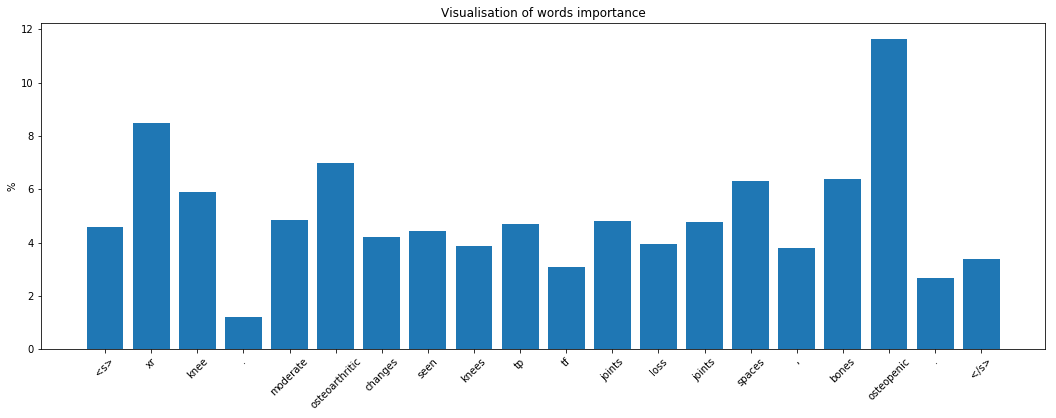

(Variable containing:
  4.0905e-02  2.9435e-02  2.8372e-01  ...   6.8168e-02 -1.1871e-02  6.2135e-03
 [torch.cuda.FloatTensor of size 1x4096 (GPU 0)],
 array([[ 7,  6, 13, ..., 16,  4,  2]]))

In [124]:
%pylab inline
pylab.rcParams['figure.figsize'] = (18, 6)

report_sample = random.choice(reports)
print "Sample document: \n"
print report_sample

model_is.visualize(report_sample, tokenize=True)

## 2.4 K-means silhouette evaluation
The silhouette score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

In [125]:
# Perform k-means on a range of k, evaluate silhouette
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def kmeans_silhouette(vectors, k_range):

    s = []
    # b = []
    # i=0
    for n_clusters in k_range:

        print n_clusters, ' clusters'
        kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=10)
        kmeans.fit(vectors)

        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_
        # bic = compute_bic(kmeans, tfidf_matrix.toarray())

        # b.append(bic)
        s.append(silhouette_score(vectors, labels, metric='euclidean'))

        #fig, ax1 = plt.subplots()
        #ax1.plot(s, 'b-')
        #ax1.set_xlabel('k')
        # Make the y-axis label, ticks and tick labels match the line color.
        #ax1.set_ylabel('Silhouette', color='b')
        #ax1.tick_params('y', colors='b')

        #ax2 = ax1.twinx()
        #ax2.plot(b, 'r.')
        #ax2.set_ylabel('BIC', color='r')
        #ax2.tick_params('y', colors='r')

        #fig.tight_layout()
        #plt.show()
    return s
        
scores = kmeans_silhouette(embeddings_is, list(range(2,50,2)))

2  clusters
4  clusters
6  clusters
8  clusters
10  clusters
12  clusters
14  clusters
16  clusters
18  clusters
20  clusters
22  clusters
24  clusters
26  clusters
28  clusters
30  clusters
32  clusters
34  clusters
36  clusters
38  clusters
40  clusters
42  clusters
44  clusters
46  clusters
48  clusters


[0.14676312, 0.090441428, 0.081233442, 0.078898937, 0.081194721, 0.078285642, 0.081315555, 0.078908175, 0.070650667, 0.076967582, 0.077805199, 0.066478387, 0.067428201, 0.072401725, 0.068383224, 0.067713208, 0.071092553, 0.071030602, 0.064721271, 0.070013992, 0.065307096, 0.073760055, 0.066589378, 0.068801753]


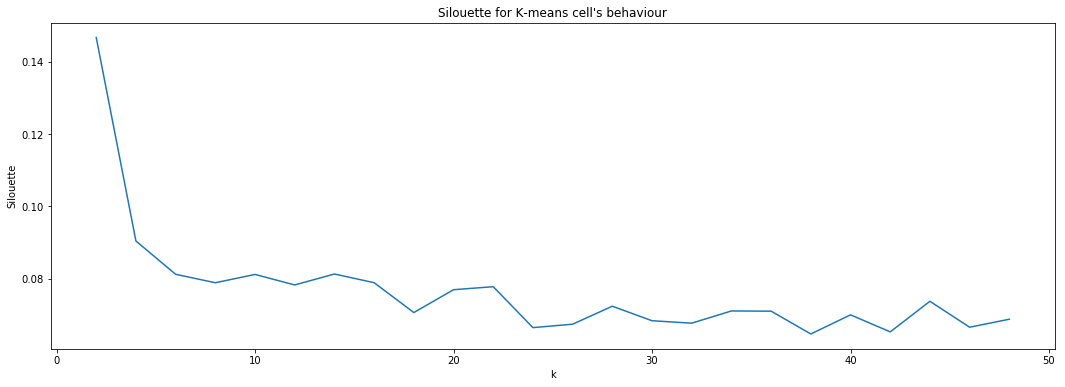

In [126]:
# print scores
plt.plot(list(range(2,50,2)), scores)
plt.ylabel("Silouette")
plt.xlabel("k")
plt.title("Silouette for K-means cell's behaviour")
plt.show()

## 2.5 K-means of InferSent embeddings

In [18]:
# Cluster documents using K-means
from sklearn.cluster import KMeans

def kmeans_clustering(vectors, num_clusters):
    # docvecs = model.docvecs
    kmeans = KMeans(init='k-means++', n_clusters=num_clusters, n_init=10)
    kmeans.fit(vectors)
    return kmeans.labels_
    
# Kmeans
num_clusters_is = 10

# print report_samples_linebreaks[1]

kmeans_labels_is = kmeans_clustering(embeddings_is, num_clusters_is)

## 2.6 PCA of clusters

<IPython.core.display.Javascript object>


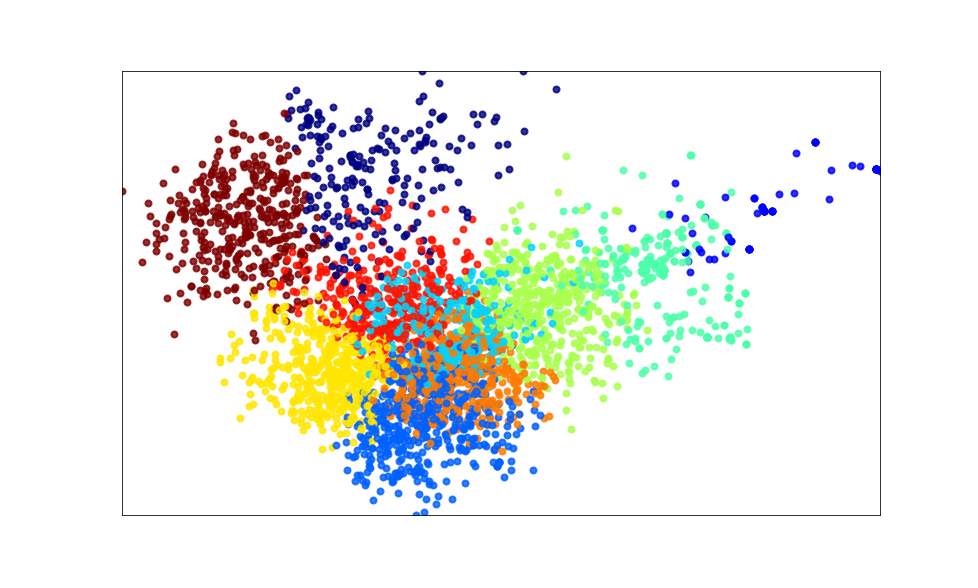

In [19]:
# Plot reports and clusters using PCA
#pylab.rcParams['figure.figsize'] = (18, 10)
%matplotlib notebook
%matplotlib notebook
#%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

def plot_pca(vectors, reports, kmeans_labels, num_clusters, num_samples):
    reports_tuple = np.array(zip(vectors, reports, kmeans_labels))
    reports_tuple[np.random.choice(len(reports_tuple),10)]
    ss_vectors = reports_tuple[:,0].tolist()
    ss_reports = reports_tuple[:,1].tolist()
    ss_kmeans_labels = reports_tuple[:,2].tolist()
    
    reduced_data = PCA(n_components=2).fit_transform(ss_vectors)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    #h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    x_min, x_max = reduced_data[:, 0].min(), reduced_data[:, 0].max()
    y_min, y_max = reduced_data[:, 1].min(), reduced_data[:, 1].max()

    plt.figure()
    plt.clf()

    colours = plt.cm.jet(np.linspace(0, 1, num_clusters))
    
    for i, x, y in zip(range(num_samples), reduced_data[:, 0], reduced_data[:, 1]):
        #plt.annotate(ss_reports[i], xy=(x, y), xytext=(0, 0), textcoords='offset points', color=colours[ss_kmeans_labels[i]])
        plt.scatter(x, y, color=colours[ss_kmeans_labels[i]], alpha=.8, lw=2)
                                        
    #plt.title('K-means Clustering of Knee X-ray Reports (reduced with PCA)\n')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

# PCA
num_samples_pca = len(reports)
report_samples_linebreaks = []
for report in reports:
    words = report.split()
    new_r = []
    for i, word in enumerate(words):
        new_r.append(word)
        if i%15==0:
            new_r.append(' \n ')
    report_samples_linebreaks.append(' '.join(new_r))

plot_pca(embeddings_is, report_samples_linebreaks, kmeans_labels_is, num_clusters_is, num_samples_pca)

## 2.7 Wordclouds of Clusters

Reports in cluster 0:  207
Sample report: 
xr knee . moderate narrowing medial joint compartment associated subchondral sclerosis osteophyte formation . appearances keeping degenerative change unchanged since december 2015 .

Reports in cluster 1:  63
Sample report: 
.

Reports in cluster 2:  546
Sample report: 
xr knee . severe medial moderate patellofemoral joint space narrowing bilaterally . findings keeping degenerative change .

Reports in cluster 3:  265
Sample report: 
xr knee presence osteoarthritic changes seen knee fp ft joints reduction joint spaces osteophytosis . tibial spiking seen .

Reports in cluster 4:  351
Sample report: 
xr knee . bone abnormality seen .

Reports in cluster 5:  448
Sample report: 
xr knee . mild narrowing left knee medial compartment . would keeping degeneration .

Reports in cluster 6:  459
Sample report: 
xr knee . mild joint space narrowing medial tibiofemoral joint compartment bilaterally moderate joint space narrowing patellofemoral joint space

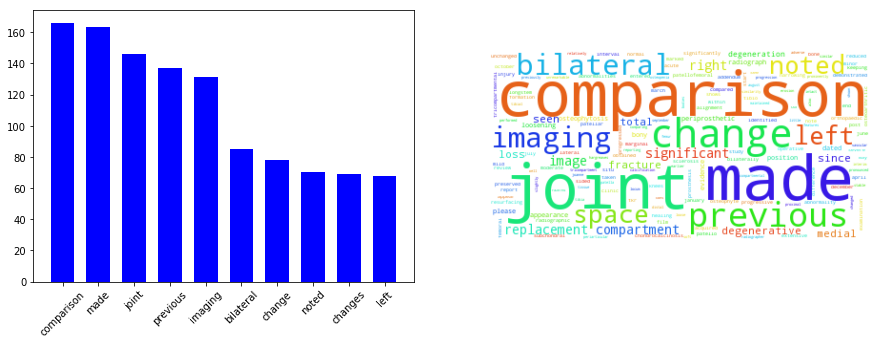

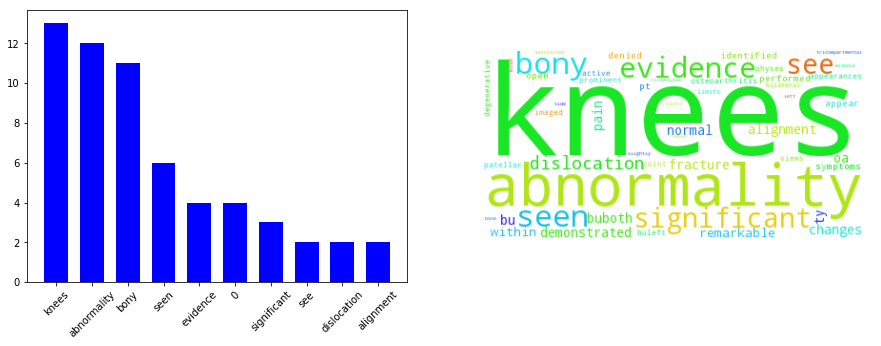

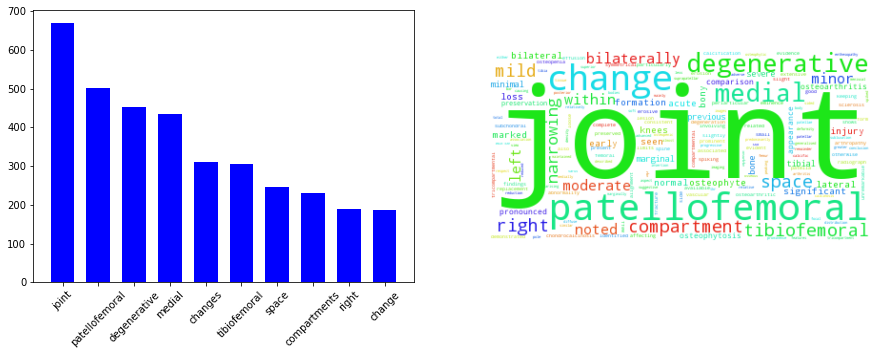

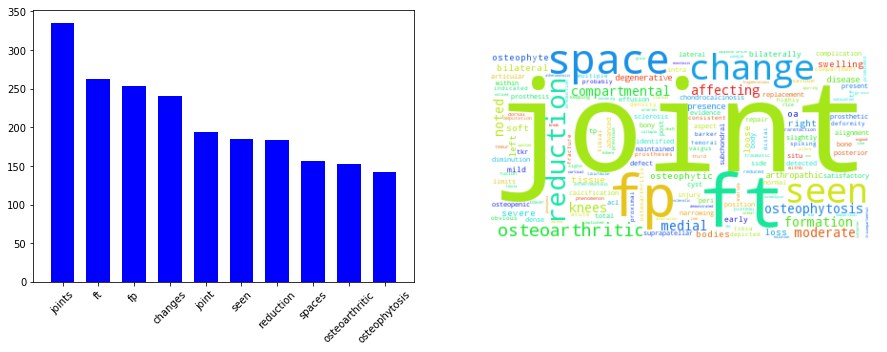

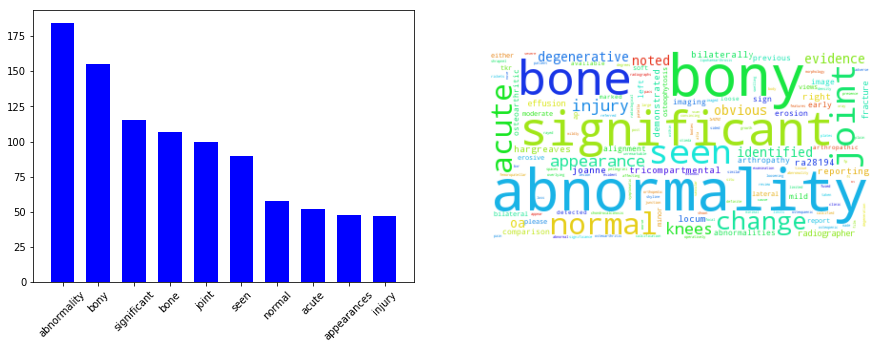

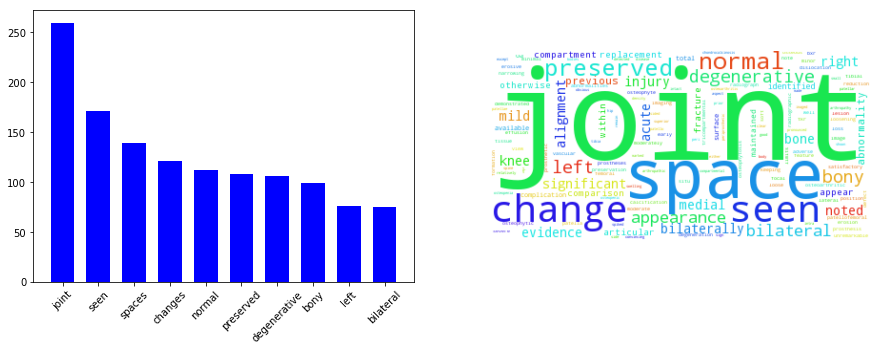

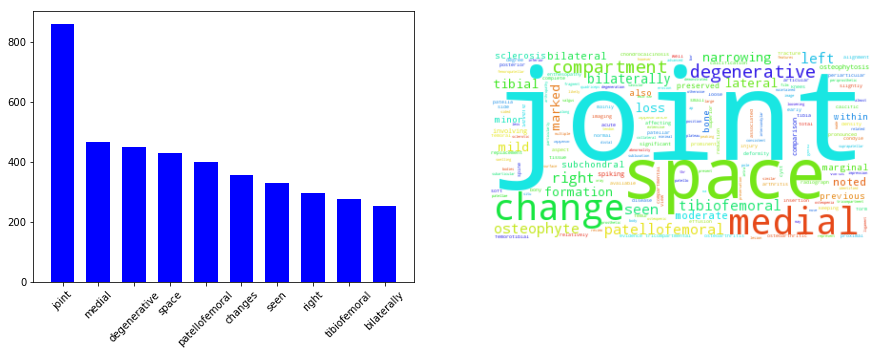

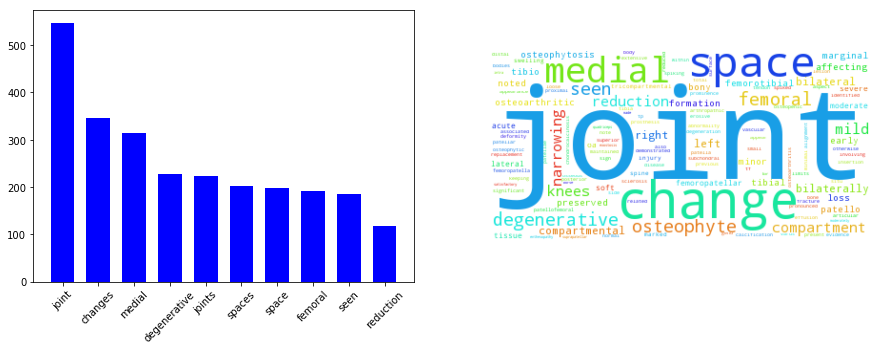

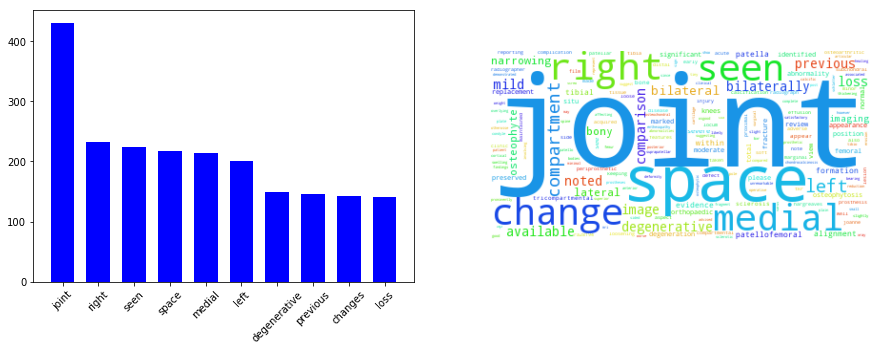

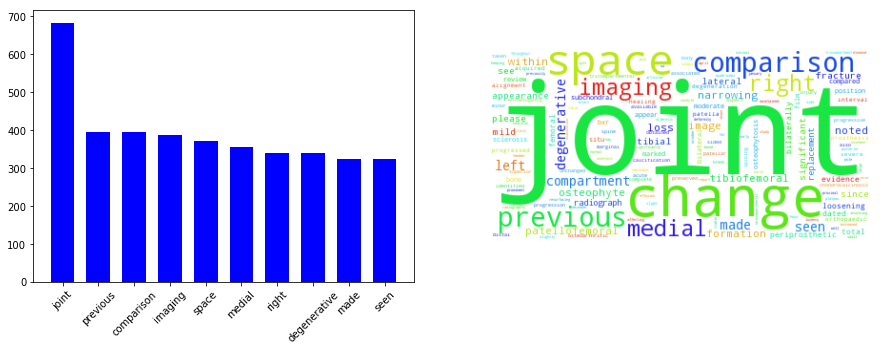

In [39]:
# Visualise words in clusters
from nltk.corpus import stopwords
from wordcloud import WordCloud
%matplotlib inline

mystoplist = ['xr', 'knee', 'both', 'x-ray', ':', '.', ',']
stoplist = mystoplist + stopwords.words('english')

clusters_is = {}
cluster_sizes = []
for k in range(num_clusters_is):
    wc = WordCloud(background_color="white")
    #report_sample =  random.sample(list(report_list))
    clusters_is["cluster{0}".format(k)] = [i for i,j in zip(reports, kmeans_labels_is) if j==k]
    cluster_sizes.append(len(clusters_is["cluster{0}".format(k)]))
    #print random.choice(list(clusters["cluster{0}".format(k)]))

    #print type(clusters["cluster{0}".format(k)])
    report_list = [report.lower() for report in clusters_is["cluster{0}".format(k)]]
    report_text = ' '.join(report_list)
    report_words = report_text.split()
    filtered_report_text = [word for word in report_words if word not in stoplist]
    
    # frequency hist
    fig, (a1,a2) = plt.subplots(1, 2, figsize=(15, 5))
    fdist_all = nltk.FreqDist(filtered_report_text)
    hist = [(word,freq) for word, freq in fdist_all.most_common(10)]
    words = [str(word) for word in zip(*hist)[0]]
    counts = range(len(words))
    frequency = zip(*hist)[1]
    a1.bar(counts, frequency, 1/1.5, color="blue", align='center')
    plt.sca(a1)
    plt.xticks(counts, words, rotation=45)
    
    # wordcloud
    wordcloud = wc.generate(' '.join(filtered_report_text))
    a2.imshow(wordcloud, interpolation='bilinear')
    a2.axis("off")
    fig.show()
    
    print 'Reports in cluster {0}: '.format(k), len(clusters_is["cluster{0}".format(k)])
    print 'Sample report: '
    print clusters_is["cluster{0}".format(k)][np.random.choice(len(clusters_is["cluster{0}".format(k)]))]
    print ''
    
# Save clusters
import json
with open('kmeans_clusters_infersent.json', 'w') as fp:
    json.dump(clusters_is, fp)

## 2.8 Explore reports in clusters
1. __Cluster 0__ has a high occurance of the phrases *'comparison made'*, *'comparing previous'*, *'changes seen since'*; which suggests this cluster of reports all make reference to previous exams. Looking closely at the reports, it becomes clear that these phrases sometimes explicitly refer to a particular exam (such as *'comparison made images dated 14 , 05 , 2015'*), but sometimes implicitly (*'appearances progressed significantly since 2013'*). However, all the reports make reference to time (year or date)

2. __Cluster 1__ has a high occurance of empty reports, and reports with the word 'abnormality'

3. __Cluster 2__ has a high occurance of words *'mild'*, *'moderate'*, *'minor'*, *'early'* when referring to *'degenerative change'*

4. __Cluster 3__ has a high occurance of the phrases *'osteoarthritic changes'*, *'joints osteophyte formations'* and *'reduction joint space'*

5. __Cluster 4__ has a high occurance of the word *'bony'* as an adjective for *'abnormality'* and *'normal appearance'*

6. __Cluster 5__ has a high occurance of the word *'prosthesis'*

7. __Cluster 6__ is a collection of the longest reports with a combination of pathologies

8. __Cluster 7__ has a high occurance of the phrase *'joint space'*

9. __Cluster 8__ also has a high occurance of the phrases *'comparison made'* and *'previous images'*, however, most do not contain any references to specific dates/years

10. __Cluster 9__ also a collection of long reports with many pathologies, but most (if not all) contain the phrases *'comparison made'* with references to specific dates/years

In [48]:
# Load json of clusters
import json
json_file = open('kmeans_clusters_infersent.json')
json_str = json_file.read()
clusters_ff = json.loads(json_str)

print 'Reports: \n'
for report in clusters_ff["cluster{0}".format(9)]:
    print report
    print ''

Reports: 

xr knee . right total knee replacement situ . evidence periprosthetic fracture loosening . marked degenerative change left knee joint extensive loss joint space medial tibiofemoral joint , sclerosis osteophyte formation . significant progression appearances compared imaging 22 , 05 , 2012 .

xr knee . comparison made previous september 2012 degenerative changes knee joints marginal osteophytosis narrowing lateral tibiofemoral joint space . significant change proggresion disease previous examination .

bxr knee leftb . comparison made imaging 12 , 11 , 2012 . previous total knee replacement noted . evidence periprosthetic fracture prosthesis loosening . please see images position healing . bxr knee right . b comparison made imaging 03 , 10 , 2011 . moderate tricompartmental degenerative change right knee noted , progressed slightly since previous imaging loss joint space .

xr knee . right knee compared previous 29 , 7 , 2013 . degenerative changes knee joints marginal osteop